In [ ]:
import os
import cv2
import shutil
import zipfile
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
!kaggle datasets download -d mohamedmaher5/vehicle-classification

with zipfile.ZipFile('vehicle-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

data_dir = './dataset/Vehicles'
train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
vehicle-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
test_ratio = 0.1
val_ratio = 0.2

for folder in [train_dir, val_dir, test_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    test_count = int(total_images * test_ratio)
    val_count = int(total_images * val_ratio)
    train_count = total_images - (test_count + val_count)

    for i, img in enumerate(images):
        src_path = os.path.join(class_path, img)

        if i < train_count:
            dst_path = os.path.join(train_dir, class_name, img)
        elif i < train_count + val_count:
            dst_path = os.path.join(val_dir, class_name, img)
        else:
            dst_path = os.path.join(test_dir, class_name, img)

        shutil.move(src_path, dst_path)

print("Train, Validation, & Test set success.")

Train, Validation, & Test set success.


In [ ]:
def count_images(directory):
    total = sum([len(files) for _, _, files in os.walk(directory)])
    return total

num_train = count_images(train_dir)
num_val = count_images(val_dir)
num_test = count_images(test_dir)

print(f"Train: {num_train}")
print(f"Validation: {num_val}")
print(f"Test: {num_test}")

Train: 5119
Validation: 2024
Test: 1058


In [ ]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5116 images belonging to 7 classes.
Found 2024 images belonging to 7 classes.


In [ ]:
def build_model():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

model = build_model()
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 886ms/step - accuracy: 0.3628 - loss: 1.6719 - val_accuracy: 0.7253 - val_loss: 0.8698 - learning_rate: 1.0000e-04
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 826ms/step - accuracy: 0.6921 - loss: 0.9112 - val_accuracy: 0.7495 - val_loss: 0.7323 - learning_rate: 1.0000e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 804ms/step - accuracy: 0.7412 - loss: 0.7752 - val_accuracy: 0.7880 - val_loss: 0.6245 - learning_rate: 1.0000e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 806ms/step - accuracy: 0.7790 - loss: 0.6451 - val_accuracy: 0.7856 - val_loss: 0.5972 - learning_rate: 1.0000e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 811ms/step - accuracy: 0.8007 - loss: 0.6054 - val_accuracy: 0.8330 - val_loss: 0.5016 - learning_rate: 1.0000e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 131s 820ms/step - accuracy: 0.8215 - loss: 0.5352 - val_accuracy: 0.8498 - val_loss: 0.4573 - learning_rate: 1.0000e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save('vehicle_classification_model.keras')

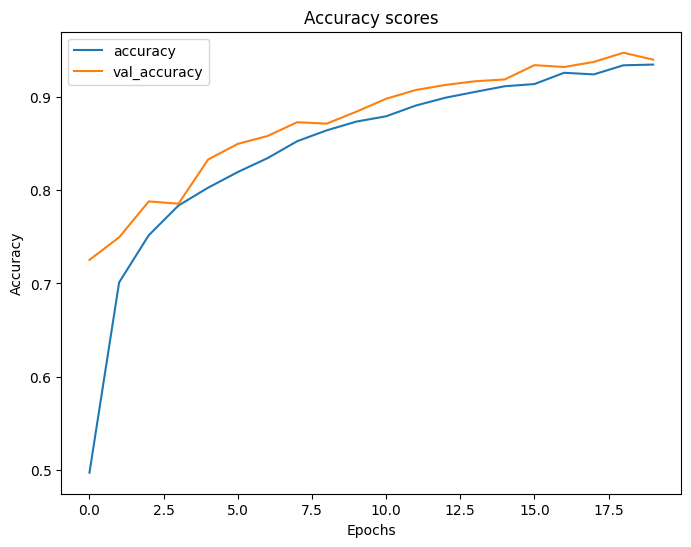

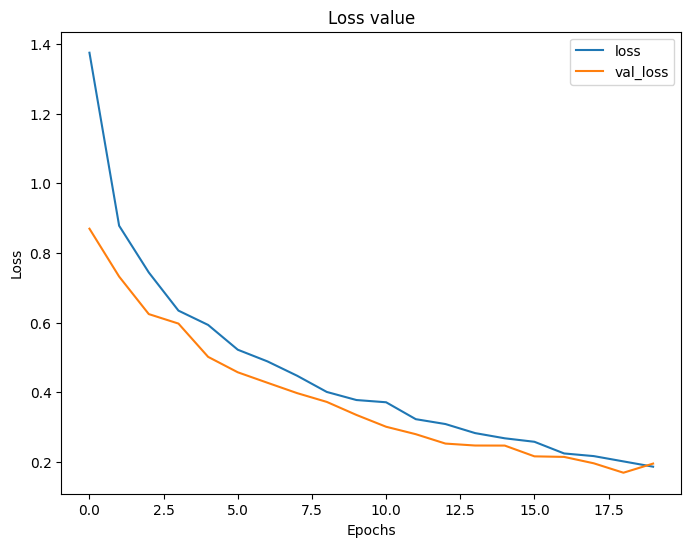

Found 1057 images belonging to 7 classes.
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 624ms/step
                precision    recall  f1-score   support

Auto Rickshaws       0.95      0.94      0.94       154
         Bikes       0.99      0.97      0.98       151
          Cars       0.92      0.91      0.91       152
   Motorcycles       0.92      0.96      0.94       149
        Planes       0.99      0.95      0.97       149
         Ships       0.98      0.96      0.97       149
        Trains       0.89      0.94      0.91       153

      accuracy                           0.95      1057
     macro avg       0.95      0.95      0.95      1057
  weighted avg       0.95      0.95      0.95      1057



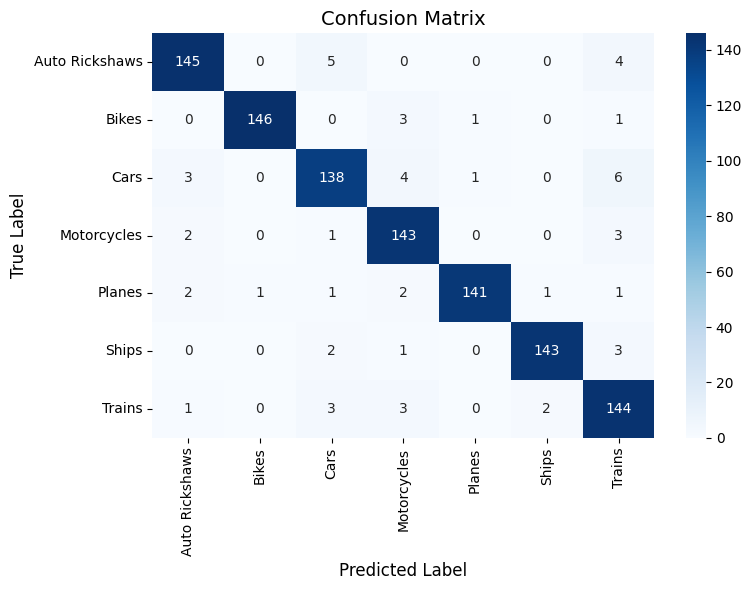

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
model.save('vehicle_classification_model2.keras')

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import os
print(os.listdir())

['.config', '.gradio', 'vehicle_classification_model.keras', 'vehicle-classification.zip', 'vehicle_classification_model2.keras', 'dataset', 'sample_data']


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

try:
    model = load_model('/content/vehicle_classification_model.keras')
except OSError as e:
    print("Error loading model:", e)

class_labels = ['Auto Rickshaw', 'Bike', 'Car', 'Motorcycle', 'Plane', 'Ship', 'Train']

def predict_vehicle(img):
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    return {
        "vehicle_type": predicted_label,
        "confidence": confidence
    }

gr.Interface(
    fn=predict_vehicle,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=gr.JSON(label="Prediction Result"),
    title="Vehicle Classification System",
    description="Upload an image of a vehicle, and the model will predict its type.",
    live=True
).launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://899c35cb484386bd7c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
